<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

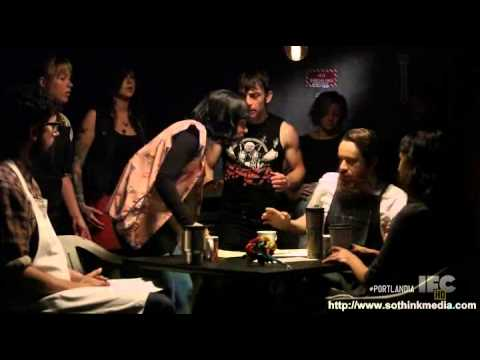

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [5]:
import pandas as pd
import re
shops = pd.read_csv('./data/yelp_coffeeshop_review_data.csv')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [6]:
import datetime
# Start here 
def tokenize(text):
    return re.sub(r'[^a-zA-Z ^0-9]', '', text).lower().split()
shops['review_date'] = shops['full_review_text'].apply(lambda x: datetime.datetime.strptime(x.split()[0], '%m/%d/%Y'))

In [7]:
shops['star_rating'] = shops['star_rating'].apply(lambda x: float(x.split()[0]))

In [8]:
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: re.sub(r'^ \d+?/\d+?/\d+? ', '', x))
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: re.sub(r'^\d* check-ins? ', '', x))



In [9]:
#lower case
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.lower())


In [10]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_md")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [77]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        t2 = zip(appears_in.keys(), appears_in.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')
        
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        wc['cul_pct_total'] = wc['pct_total'].cumsum()
        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        wc = wc.sort_values(by='rank')
        

        
        
        return wc.sort_values(by='rank')

In [39]:
STOP_WORDS = nlp.Defaults.stop_words.union(['i', 'and', ' ', 'to', 'be', '\'s', 'with', 'the', 'and', 'i'])

In [41]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.lemma_ not in STOP_WORDS) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
            print(f'token: {token}, pos {token.pos_}, lemma: {token.lemma_}')
    return lemmas

In [42]:
shops['full_review_text'][25:26].apply(get_lemmas)

token: okay, pos INTJ, lemma: okay
token: visiting, pos VERB, lemma: visit
token: my, pos ADJ, lemma: -PRON-
token: friends, pos NOUN, lemma: friend
token: la, pos NOUN, lemma: la
token: trying, pos VERB, lemma: try
token: mint, pos NOUN, lemma: mint
token: mojito, pos NOUN, lemma: mojito
token: iced, pos VERB, lemma: ice
token: coffee, pos NOUN, lemma: coffee
token: find, pos VERB, lemma: find
token: austin, pos PROPN, lemma: austin
token: comparable, pos ADJ, lemma: comparable
token: difficult, pos ADJ, lemma: difficult
token: find, pos VERB, lemma: find
token: begin, pos VERB, lemma: begin
token: let, pos VERB, lemma: let
token: good, pos ADJ, lemma: good
token: mint, pos NOUN, lemma: mint
token: coffee, pos NOUN, lemma: coffee
token: factory, pos NOUN, lemma: factory
token: website, pos NOUN, lemma: website
token: try, pos VERB, lemma: try
token: unfortunately, pos ADV, lemma: unfortunately
token: shell, pos NOUN, lemma: shell
token: shocked, pos VERB, lemma: shock
token: price, po

25    [okay, visit, -PRON-, friend, la, try, mint, m...
Name: full_review_text, dtype: object

In [47]:

def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.lemma_ not in STOP_WORDS) and (token.is_punct == False)) and (token.lemma_!= '-PRON-'):
            lemmas.append(token.lemma_)
    return lemmas
shops['lemma'] = shops['full_review_text'].apply(get_lemmas)

In [44]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,lemma
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,5.0,2016-11-25,"[love, love, love, the, atmosphere, every, cor..."
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4.0,2016-12-02,"[list, in, date, night, austin, ambiance, in, ..."
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4.0,2016-11-30,"[list, in, brunch, spot, i, love, the, eclecti..."
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating how...,2.0,2016-11-25,"[very, cool, decor, good, drink, nice, seating..."
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4.0,2016-12-03,"[be, locate, within, the, northcross, mall, sh..."


In [116]:
base = count(shops['lemma']).set_index('word')

In [125]:
base.loc['coffee']

appears_in         4952.000000
count             10762.000000
pct_total             0.030894
cul_pct_total         0.053547
rank                  1.000000
appears_in_pct        0.650210
Name: coffee, dtype: float64

Index(['coffee', 'place', 'good', 'great', 'like', 'come', 'time', 'love',
       'drink', 'austin',
       ...
       'mum', 'lentil', 'foodgasm', 'uneventful', 'predictably', 'romaine',
       'windowed', 'actuality', 'crass', 'digestion'],
      dtype='object', name='word', length=14484)

In [135]:
five_star = count(shops[shops['star_rating']==5]['lemma']).set_index('word')
five_star['appears_in_pct_diff'] = five_star.apply(lambda x: x['appears_in_pct'] - base.loc[x.name]['appears_in_pct'], axis=1)
five_star.sort_values(by='appears_in_pct_diff', ascending=False).head(10)

,appears_in,count,pct_total,cul_pct_total,rank,appears_in_pct,appears_in_pct_diff
word,,,,,,,
love,1116,1511,0.009734,0.068899,5.0,0.295238,0.056005
amazing,539,624,0.004020,0.434477,24.0,0.142593,0.046348
delicious,801,903,0.005817,0.418687,15.0,0.211905,0.045938
great,1565,2193,0.014128,0.411994,4.0,0.414021,0.038496
friendly,949,1001,0.006449,0.127728,11.0,0.251058,0.036379
favorite,473,562,0.003620,0.182132,32.0,0.125132,0.031776
awesome,418,464,0.002989,0.307329,42.0,0.110582,0.031144
austin,1022,1322,0.008517,0.328620,6.0,0.270370,0.029036
staff,701,737,0.004748,0.388880,18.0,0.185450,0.026048


In [137]:
one_star = count(shops[shops['star_rating']==1]['lemma']).set_index('word')
one_star['appears_in_pct_diff'] = one_star.apply(lambda x: x['appears_in_pct'] - base.loc[x.name]['appears_in_pct'], axis=1)
one_star.sort_values(by='appears_in_pct_diff', ascending=False).head(10)

,appears_in,count,pct_total,cul_pct_total,rank,appears_in_pct,appears_in_pct_diff
word,,,,,,,
service,94,130,0.009097,0.037576,6.0,0.338129,0.178860
ask,69,108,0.007557,0.392065,11.0,0.248201,0.178480
customer,65,112,0.007837,0.170457,10.0,0.233813,0.173151
order,98,185,0.012945,0.069484,3.0,0.352518,0.162392
bad,59,74,0.005178,0.443986,17.0,0.212230,0.155770
rude,46,66,0.004618,0.369673,25.0,0.165468,0.150237
$,61,98,0.006857,0.056539,13.0,0.219424,0.139067
employee,45,65,0.004548,0.156882,26.0,0.161871,0.132721
tell,51,71,0.004968,0.413337,21.0,0.183453,0.131983


In [139]:
one_star.sort_values(by='appears_in_pct_diff').head(10)

,appears_in,count,pct_total,cul_pct_total,rank,appears_in_pct,appears_in_pct_diff
word,,,,,,,
great,40,61,0.004268,0.316773,27.0,0.143885,-0.231640
love,18,24,0.001679,0.357778,100.0,0.064748,-0.174485
good,94,139,0.009726,0.017703,5.0,0.338129,-0.165153
friendly,15,17,0.001190,0.686236,158.0,0.053957,-0.160723
delicious,4,4,0.000280,0.884823,761.0,0.014388,-0.151578
coffee,143,325,0.022742,0.112518,1.0,0.514388,-0.135822
austin,39,45,0.003149,0.137989,43.0,0.140288,-0.101046
seating,4,4,0.000280,0.299279,664.0,0.014388,-0.090654
nice,30,35,0.002449,0.529704,59.0,0.107914,-0.090091


In [152]:
positive_tokens = list(five_star.sort_values(by='appears_in_pct_diff', ascending=False).head(10).index)
stars = [1,2,3,4,5]
data = []
for token in positive_tokens:
    row = [token,]
    for star in stars:
        appears_pct = count(shops[shops['star_rating']==star]['lemma']).set_index('word').loc[token]['appears_in_pct']
        row.append(appears_pct)
    data.append(row)
positive = pd.DataFrame(data=data, columns=['word', '1 star', '2 star', '3 star', '4 star', '5 star'])


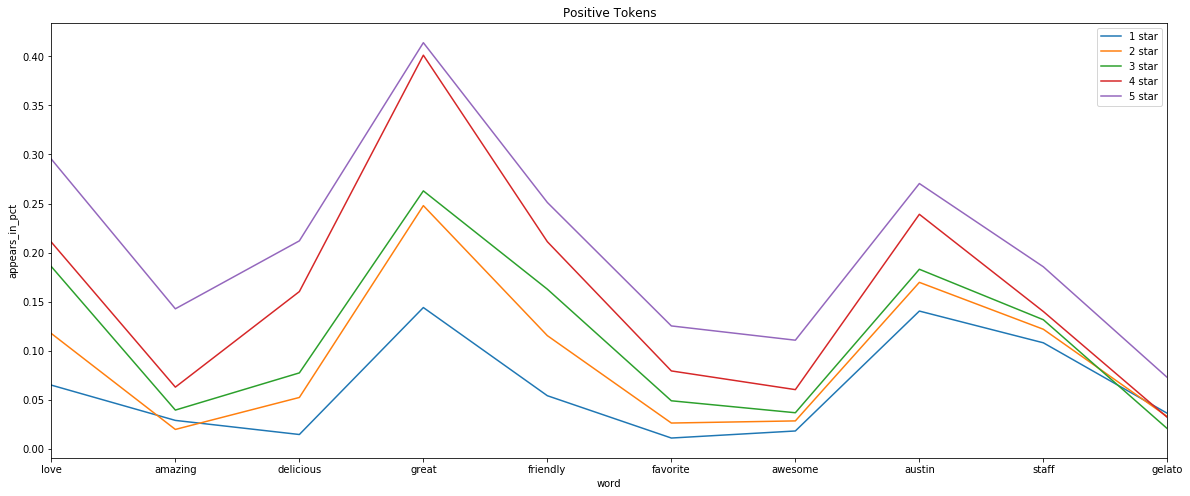

In [210]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
ax = plt.gca()
for x in range(5):
    positive.plot(kind='line', x='word', y=f'{x+1} star', ax=ax)
plt.ylabel('appears_in_pct')
plt.title('Positive Tokens')
plt.show()

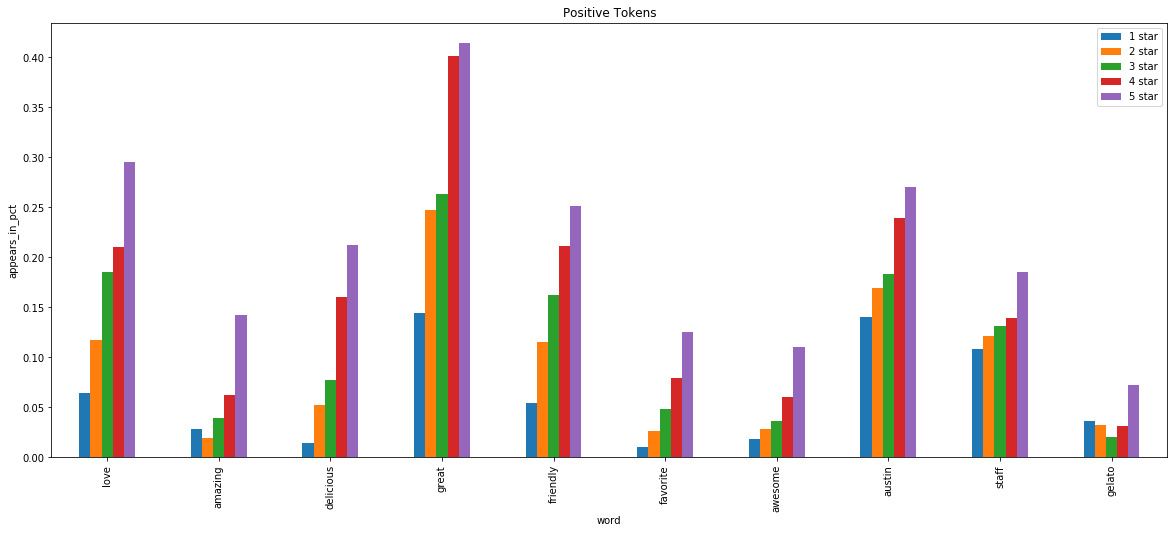

In [211]:
positive.set_index('word').plot.bar()
plt.ylabel('appears_in_pct')
plt.title('Positive Tokens')
plt.show()

In [207]:
negative_tokens = list(one_star.sort_values(by='appears_in_pct_diff', ascending=False).head(10).index)
stars = [1,2,3,4,5]
data = []
for token in negative_tokens:
    row = [token,]
    for star in stars:
        appears_pct = count(shops[shops['star_rating']==star]['lemma']).set_index('word').loc[token]['appears_in_pct']
        row.append(appears_pct)
    data.append(row)
negative = pd.DataFrame(data=data, columns=['word', '1 star', '2 star', '3 star', '4 star', '5 star'])


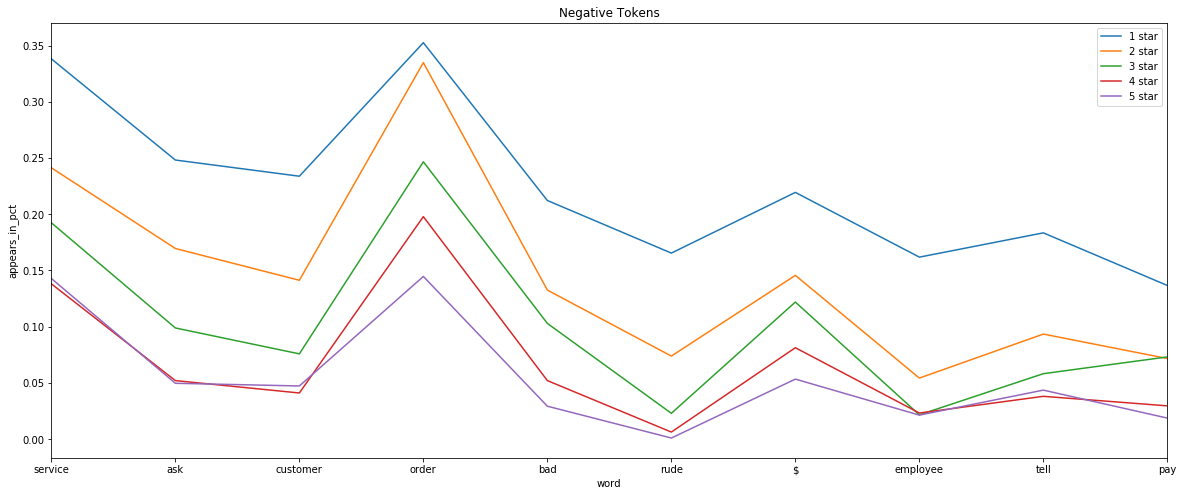

In [212]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
ax = plt.gca()
for x in range(5):
    negative.plot(kind='line', x='word', y=f'{x+1} star', ax=ax)
plt.ylabel('appears_in_pct')
plt.title('Negative Tokens')
plt.show()

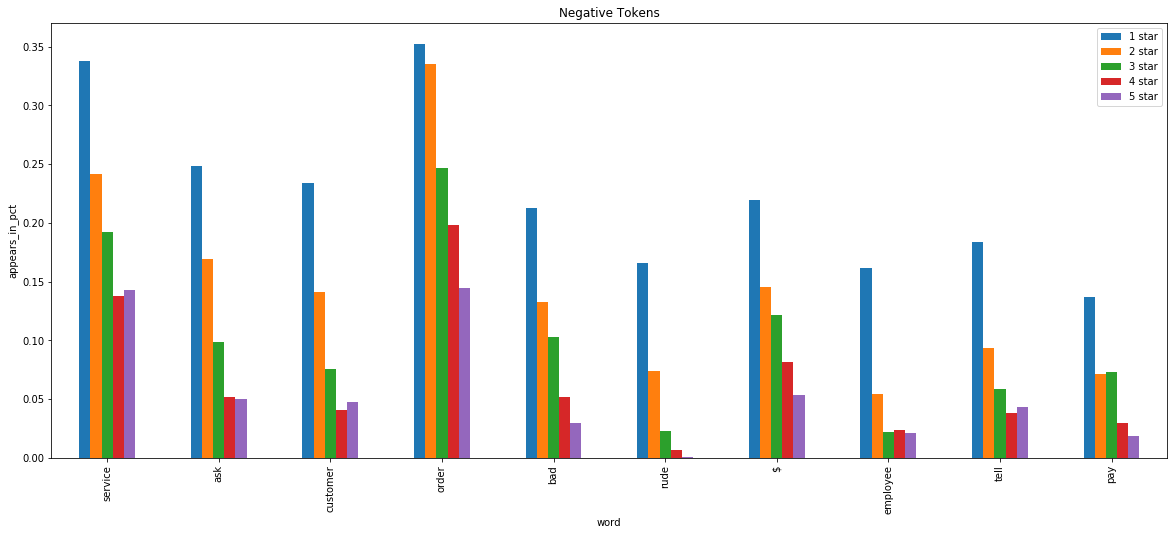

In [214]:
negative.set_index('word').plot.bar()
plt.ylabel('appears_in_pct')
plt.title('Negative Tokens')
plt.show()

Most of the positive tokens seems pretty obvious. Poeple are more likely to put positive words like 'amazing', 'great', 'delicious' on high rating reviews. Higher mention rates of 'friendly' and 'staff' also correlates to higher ratings.  Something that's not initially obvious to me was that customers are more likely to mention the place on their review if they had a good experience.

Aside from the obvious negative word tokens, mentions of higher mention rates of the words 'customer', 'service' is a good indicator of a negative review. Customers are also more likely to have something to say about the order and the price when leaving a bad review. Another interesting note is the usage of the word 'employee' for negative reviews and 'staff' for positive ones.


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

